In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.special import softmax

import pandas as pd

from tensorboardX import SummaryWriter
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.preprocessing import scale

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA

import math

In [2]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=28
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [3]:
K = 2

In [4]:
def RandomFunction(x):
    n = 2
    N = np.arange(1, n + 1, 1)
    A = np.random.randn(n)
    B = np.random.randn(n)
    A0 = np.random.randn(1)
    
    y = 0.5*np.ones_like(x)*A0
    
    for n, a, b in zip(N, A, B):
        y += a*np.sin(n*x) + b*np.cos(n*x)
    
    return y

def GenerateImpulses(n = 20, T = 2, k = 2, function = np.sin):
    
    t = int(T)//2
    
    x = np.linspace(start = 0, stop = T*np.pi, num = n)
    
    List_y = []
    
    for i in range(k):
        y_temp = 5*np.random.randn()*function(x + np.random.rand()*2*np.pi)
        List_y.append(y_temp)
    
    y = np.array(List_y[0])
    
    y2 = List_y[np.random.randint(0, k)]
    
    for i in range(0, t):
        if np.random.rand() < 0.1:
            y2 = List_y[np.random.randint(0, k)]
        
        ind = np.where(x <= 2*(i + 1)*np.pi)
        ind = np.where(x[ind] > 2*i*np.pi)
        y[ind] = y2[ind]
        
    return y
    

def GeneratorOfTimeSeries(n = 100, m = 16384, k = 20):
    T1 = []
    T2 = []
    T3 = []
    for _ in range(m):
        numPi = 80 + np.random.randint(0, 20)
        numPi = n//k
        function = np.sin
        if np.random.rand() < -4*0.5:
            function = RandomFunction
            
        series = GenerateImpulses(n = n, T = numPi, k = np.random.randint(K, K+1), function=function)
        T1.append(series + 0.5*np.random.randn(n))
    T1 = np.asarray(T1)
    
    return np.reshape(T1, [T1.shape[0], T1.shape[1], 1])

  
class TimeSeries(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TimeSeries, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [5]:
# X_train = GeneratorOfTimeSeries(n = 2000, m = 1)

In [6]:
# X_test = GeneratorOfTimeSeries(n = 1000, m = 1, k = 20)

In [7]:
# X_test = pd.read_csv('./SyntheticData/3_patern/2.csv').values.reshape([1,-1,1])

In [8]:
data = pd.read_csv('./RealData/1.csv')

In [9]:
data.head()

time_tick  acc_X_value  acc_Y_value  acc_Z_value
0   0.005672    -0.619522    -4.519217    -8.412478
1   0.038481    -0.554726    -4.954678    -8.640084
2   0.071816    -1.120077    -5.481571    -8.957926
3   0.105301    -0.375454    -5.220145    -9.323205
4   0.138501    -0.327868    -5.339859    -9.811938

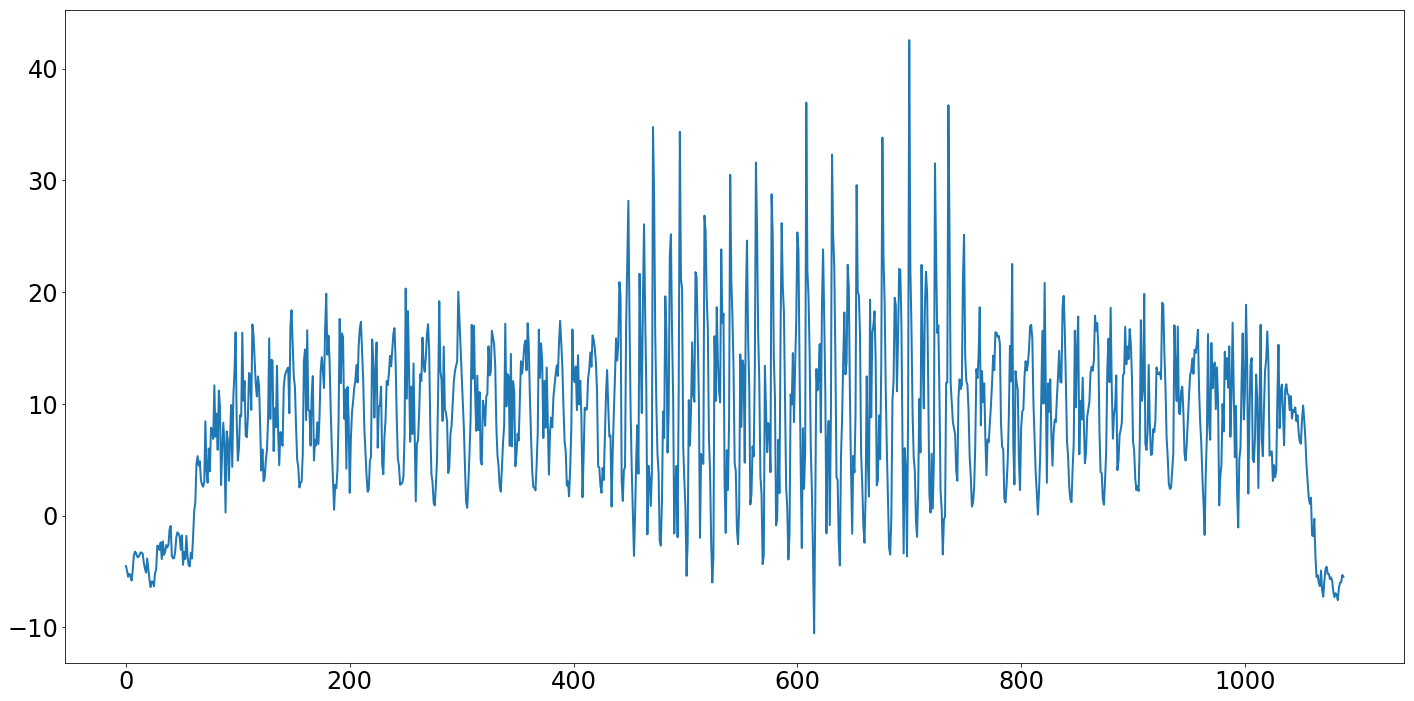

In [10]:
plt.plot(data.values[:, 2:3])

In [11]:
X_test = data.values[100:1000, 2:3].reshape([1,-1,1])

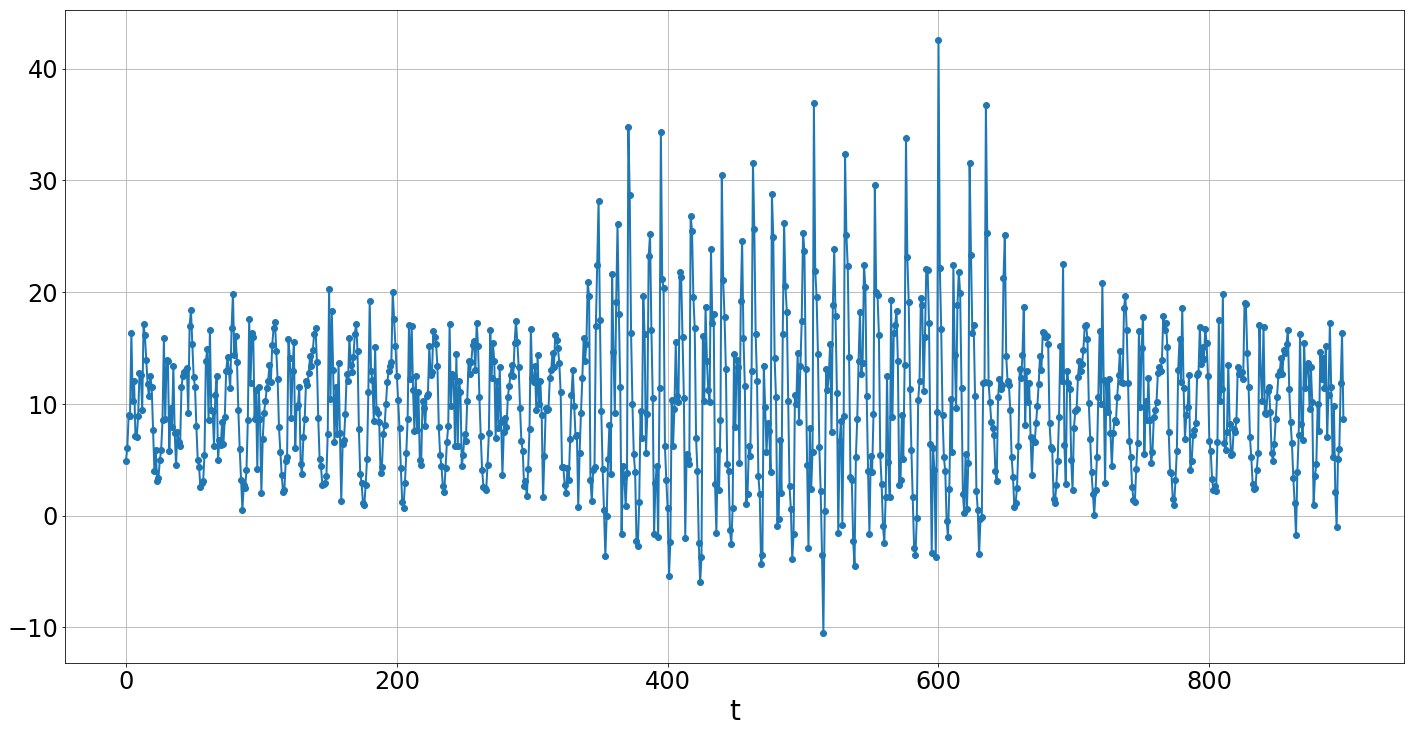

In [12]:
_ = plt.plot(X_test[0], '-o')

plt.xlabel('t')
plt.grid()
# plt.savefig('./results/1_real_series')
plt.show()

In [13]:
# dataframe = pd.DataFrame(X_test[0])
# dataframe.to_csv('./SyntheticData/2_patern/4.csv', index = False)
# dataframe.to_csv('./SyntheticData/3_patern/3.csv', index = False)
# dataframe.to_csv('./SyntheticData/4_patern/1.csv', index = False)

In [14]:
def return_h(input, i, l = 10):
    return np.sum(input[:, i:i+l, :], axis = -1)

def return_phase_track(input, l = 10):
    """
    input has a shape [batch_size, time_len, 1]
    """

    phase_track = np.zeros([input.shape[0], input.shape[1] - l, l])
    
    for i in range(0, input.shape[1] - l):
        phase_track[:, i, :] = return_h(input, i, l)
    
    return phase_track
    
    

Код для сломаной трости

In [15]:
# ramp = lambda u: np.maximum( u, 0 )
# step = lambda u: ( u > 0 ).astype(float)

# def SegmentedLinearReg( X, Y, breakpoints ):
#     nIterationMax = 200

#     breakpoints = np.sort( np.array(breakpoints) )

#     dt = np.min( np.diff(X) )
#     ones = np.ones_like(X)

#     for i in range( nIterationMax ):
#         # Linear regression:  solve A*p = Y
#         Rk = [ramp( X - xk ) for xk in breakpoints ]
#         Sk = [step( X - xk ) for xk in breakpoints ]
#         A = np.array([ ones, X ] + Rk + Sk )
#         p =  np.linalg.lstsq(A.transpose(), Y, rcond=None)[0] 

#         # Parameters identification:
#         a, b = p[0:2]
#         ck = p[ 2:2+len(breakpoints) ]
#         dk = p[ 2+len(breakpoints): ]

#         # Estimation of the next break-points:
#         newBreakpoints = breakpoints - dk/ck 

#         # Stop condition
#         if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
#             break

#         breakpoints = newBreakpoints
#     else:
#         print( 'maximum iteration reached' )

#     # Compute the final segmented fit:
#     Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
#     ones =  np.ones_like(Xsolution) 
#     Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

#     Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )
#     return Xsolution, Ysolution, breakpoints

In [16]:
T = 20

In [17]:
res = return_phase_track(X_test, T)

In [18]:
res.shape

(1, 880, 20)

In [19]:
List_of_point = []
List_of_x = []
List_of_s = []
List_of_u = []
List_of_v = []

for n in tqdm(range(T, res[0].shape[0], 1)):
    if n-2*T > 0:
        arr = res[0][n-2*T:n]
    else:
        arr = res[0][:n]
        
    u, s, v = np.linalg.svd(arr)
    x = np.array(np.arange(0, s.shape[0], 1), dtype=float)
    y = np.array(s[::-1])

    List_of_x.append(n)
    
    List_of_s.append(s)
    List_of_u.append(u)
    List_of_v.append(v)
    

In [20]:
List_of_s = np.array(List_of_s)
List_of_u = np.array(List_of_u)
List_of_v = np.array(List_of_v)
List_of_x = np.array(List_of_x)

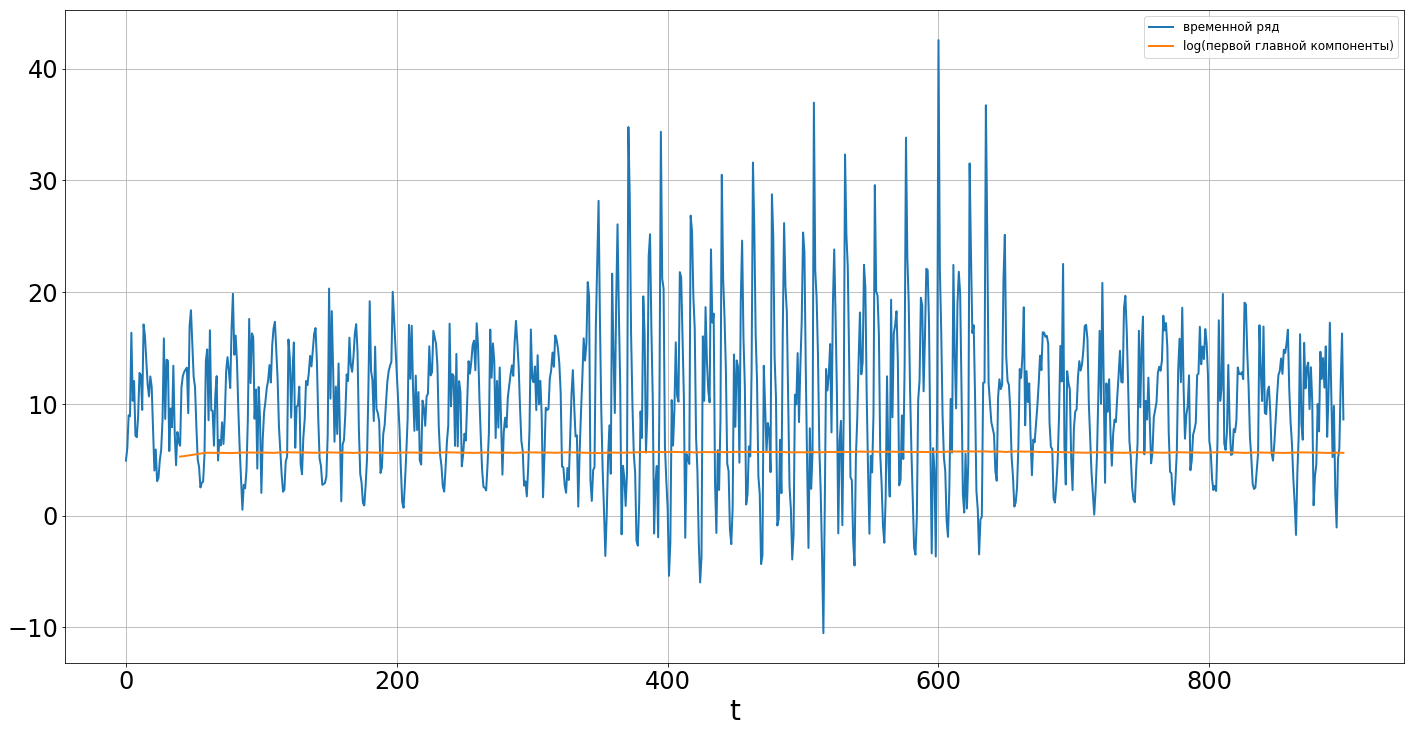

In [21]:
plt.plot(X_test[0], '-', label = 'временной ряд')
plt.plot(List_of_x+T, np.log(List_of_s[:,0]), '-', label = 'log(первой главной компоненты)')

plt.grid()
plt.xlabel('t')
plt.legend(loc = 'best')
plt.show()

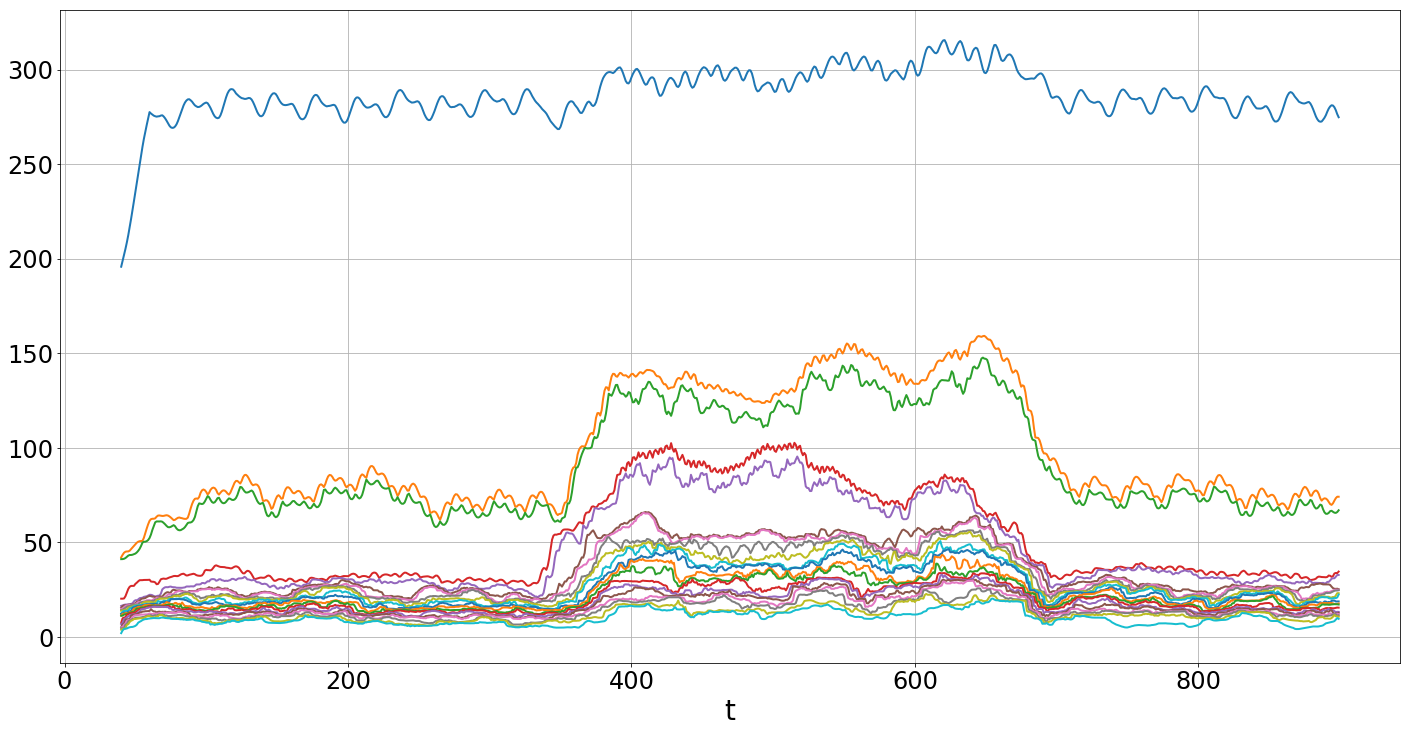

In [22]:
_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')


plt.grid()
plt.xlabel('t')
plt.savefig('./results/1_real_lambda.png')
plt.show()

In [23]:
# model_pca = PCA(n_components=20)
# result_pca_1 = model_pca.fit_transform(res[0])

In [24]:
result_pca_1 = res[0]

In [25]:
res[0].shape

(880, 20)

In [26]:
result_pca_1.shape

(880, 20)

In [27]:
List_of_basis_vector = []
List_of_basis_vector_s = []
List_of_basis_vector_c = []

model_pca = PCA(n_components=2)

for n in tqdm(range(T, result_pca_1.shape[0], 1)):
    if n-2*T > 0:
        arr = result_pca_1[n-2*T:n]
    else:
        arr = result_pca_1[:n]
    
    model_pca_answ = model_pca.fit_transform(arr)
    
    List_of_basis_vector_s.append(model_pca.singular_values_)
    
    List_of_basis_vector_c.append(model_pca_answ[-1])
    List_of_basis_vector.append(model_pca.components_)


In [28]:
List_of_basis_vector = np.array(List_of_basis_vector)
List_of_basis_vector_s = np.array(List_of_basis_vector_s)
List_of_basis_vector_c = np.array(List_of_basis_vector_c)


In [29]:
List_of_basis_vector.shape

(860, 2, 20)

In [30]:
Volum = np.zeros([2, List_of_basis_vector.shape[0], List_of_basis_vector.shape[0]])


In [31]:
cos_beta = np.abs(List_of_basis_vector[:, 0, :]@List_of_basis_vector[:, 1, :].T)
cos_alpha = np.array(np.diagonal(cos_beta))
cos_gamma = np.abs(List_of_basis_vector[:, 1, :]@List_of_basis_vector[:, 1, :].T)


In [32]:
cos_beta[np.where(cos_beta > 1-10**(-10))] = 1-10**(-10)
cos_alpha[np.where(cos_alpha > 1-10**(-10))] = 1-10**(-10)
cos_gamma[np.where(cos_gamma > 1-10**(-10))] = 1-10**(-10)

In [33]:
cos_beta[np.where(cos_beta < 10**(-10))] = 0
cos_alpha[np.where(cos_alpha < 10**(-10))] = 0
cos_gamma[np.where(cos_gamma < 10**(-10))] = 0

In [34]:
temp_a = np.sqrt(1-cos_beta**2)
cos_A = np.abs((cos_alpha.reshape([-1,1]) - cos_gamma*cos_beta)/(np.sqrt(1-cos_gamma**2)*np.sqrt(1-cos_beta**2)))
h = temp_a*np.sqrt(1-cos_A**2)

Volum[0] = h* np.sqrt(1-cos_gamma**2)
        
        

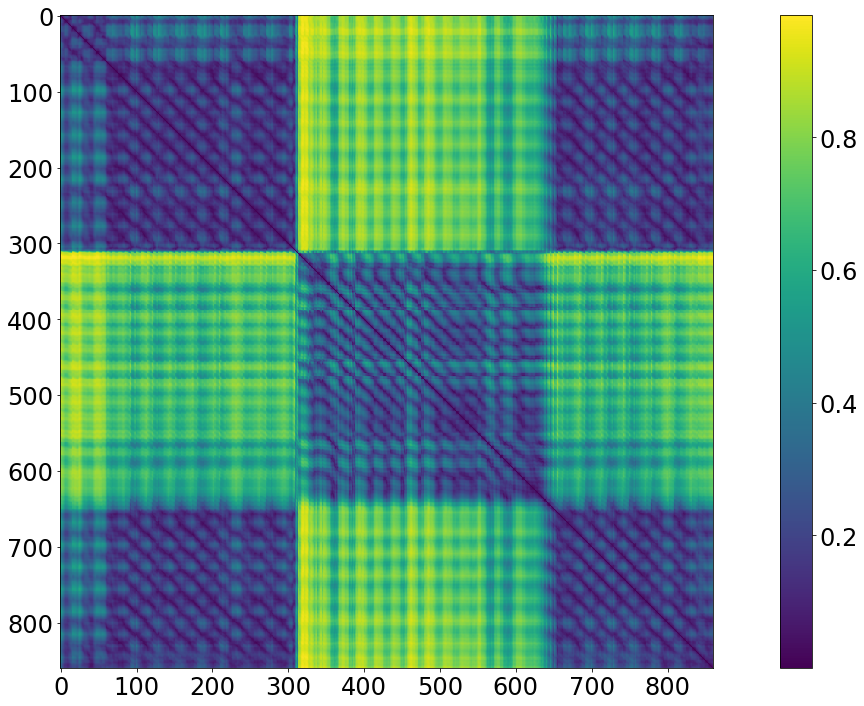

In [35]:
_ = plt.imshow(Volum[0])

_ = plt.colorbar()

In [36]:
cos_beta = np.abs(List_of_basis_vector[:, 0, :]@List_of_basis_vector[:, 0, :].T)
cos_gamma = np.abs(List_of_basis_vector[:, 1, :]@List_of_basis_vector[:, 0, :].T)

cos_alpha = np.array(np.diagonal(cos_gamma))


In [37]:
cos_beta[np.where(cos_beta > 1-10**(-10))] = 1-10**(-10)
cos_alpha[np.where(cos_alpha > 1-10**(-10))] = 1-10**(-10)
cos_gamma[np.where(cos_gamma > 1-10**(-10))] = 1-10**(-10)

In [38]:
cos_beta[np.where(cos_beta < 10**(-10))] = 0
cos_alpha[np.where(cos_alpha < 10**(-10))] = 0
cos_gamma[np.where(cos_gamma < 10**(-10))] = 0

In [39]:
temp_a = np.sqrt(1-cos_beta**2)
cos_A = (cos_alpha.reshape([-1,1]) - cos_gamma*cos_beta)/(np.sqrt(1-cos_gamma**2)*np.sqrt(1-cos_beta**2))
h = temp_a*np.sqrt(1-cos_A**2)

Volum[1] = h* np.sqrt(1-cos_gamma**2)
        

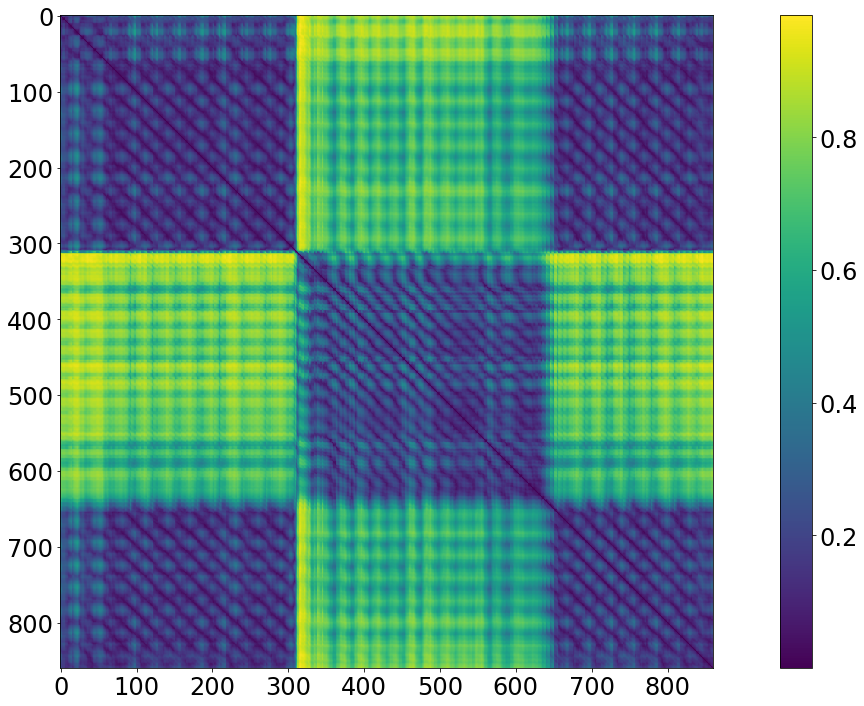

In [40]:
_ = plt.imshow(Volum[1])


_ = plt.colorbar()

In [41]:
vol = np.max(Volum, axis = 0)

In [42]:
vol.shape

(860, 860)

In [43]:
for i in tqdm(range(vol.shape[0])):
    for j in range(vol.shape[0]):
        vol[i,j] = max(vol[i,j], vol[j,i])

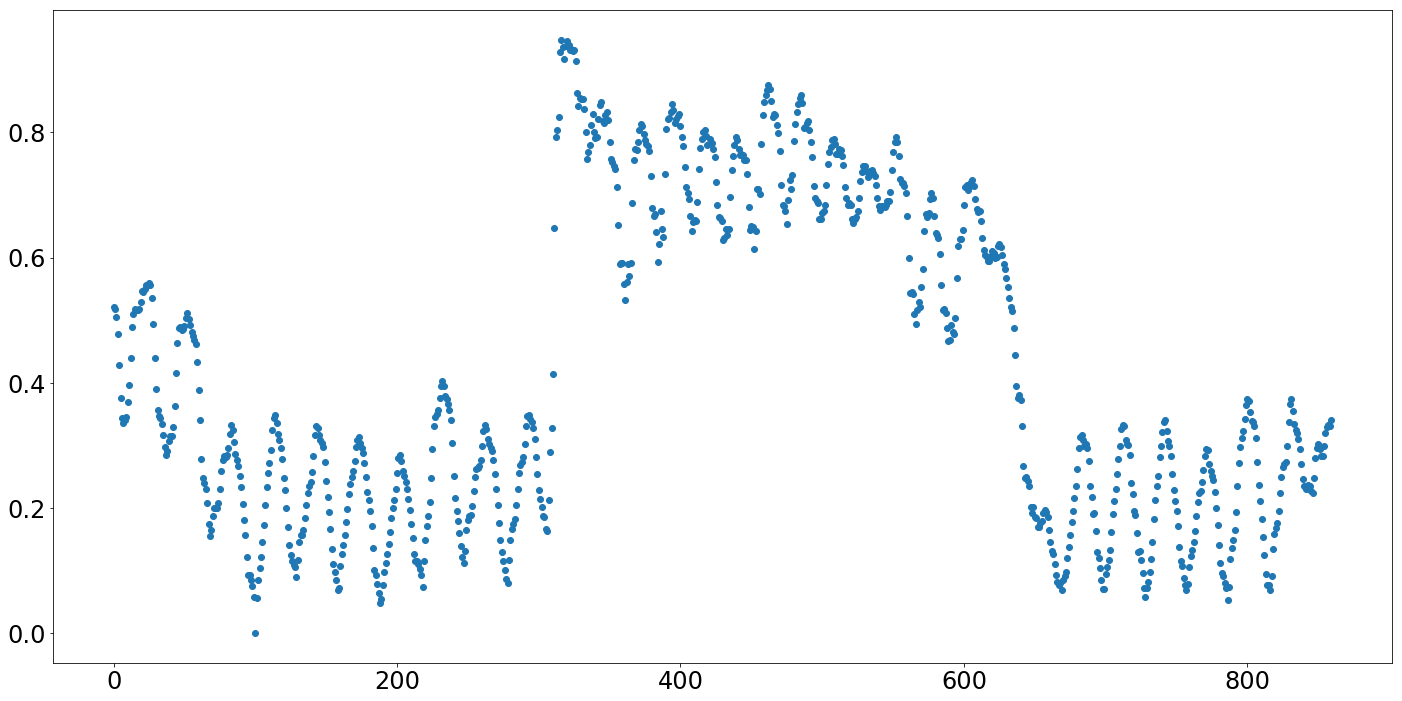

In [44]:
_ = plt.plot(vol[100], 'o')

In [45]:
vol.shape

(860, 860)

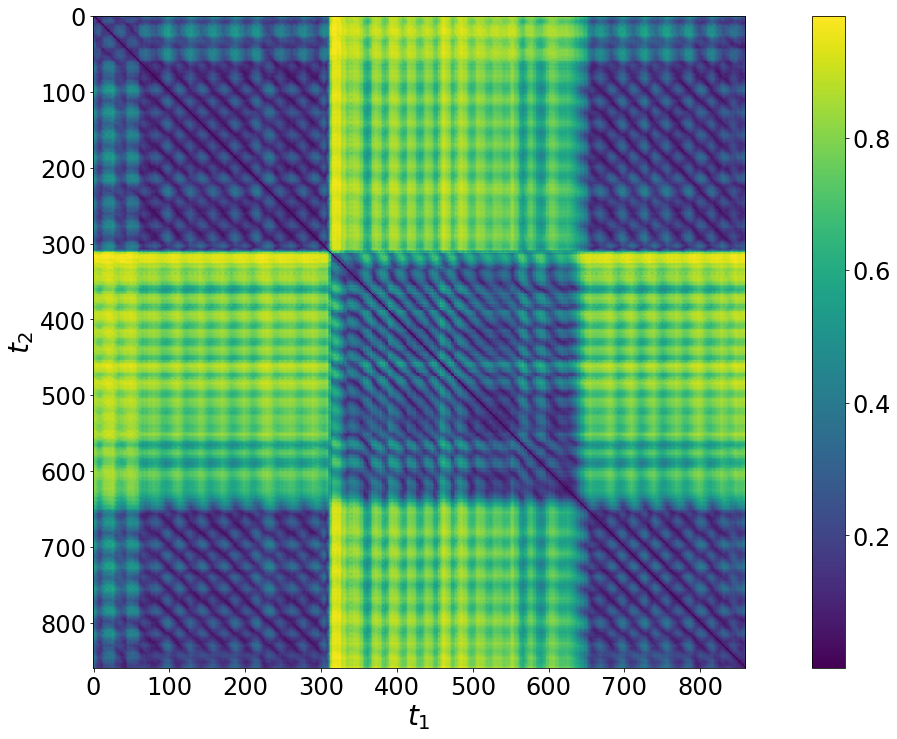

In [46]:
_ = plt.imshow(vol)

_ = plt.colorbar()

plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.savefig('./results/1_real_volum.png')
plt.show()

In [47]:
dist = np.sqrt((List_of_s[:, :1] - List_of_s[:, :1].T)**2 + (List_of_s[:, 1:2] - List_of_s[:, 1:2].T)**2)
dist = dist/np.max(dist)

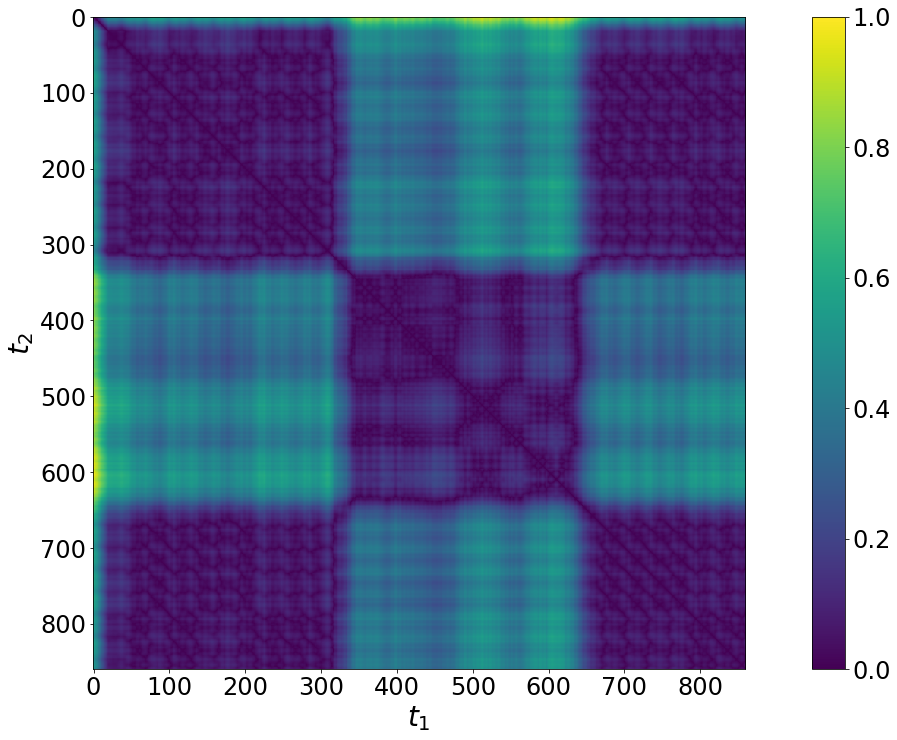

In [48]:
_ = plt.imshow(dist)

_ = plt.colorbar()

plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.savefig('./results/1_real_l2.png')
plt.show()

In [49]:
full_dist = np.sqrt(vol**2+dist**2)

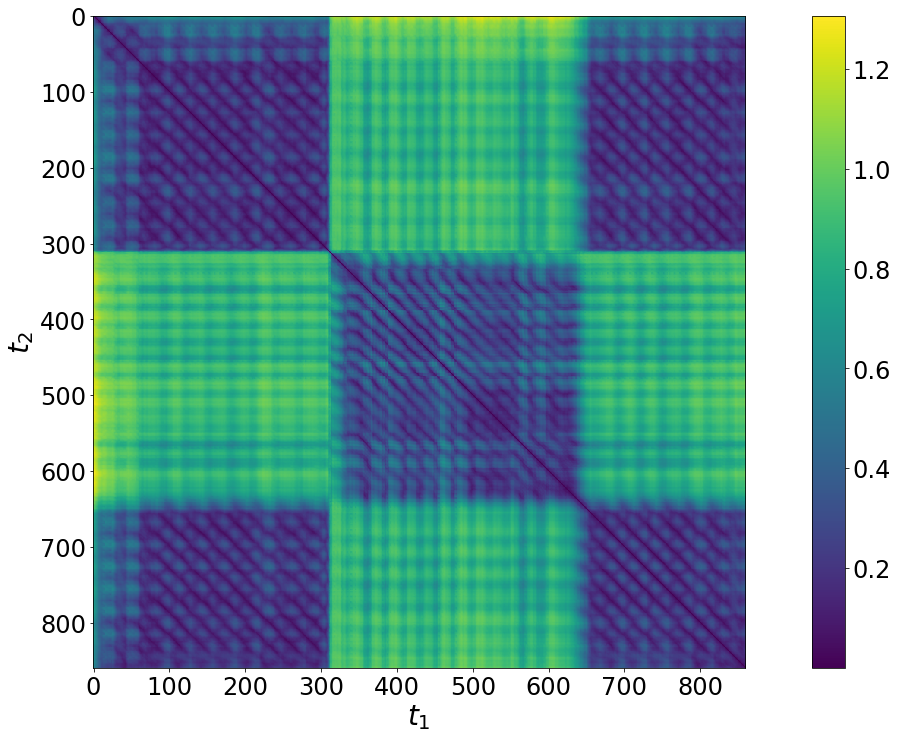

In [50]:
_ = plt.imshow(full_dist)

_ = plt.colorbar()

plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.savefig('./results/1_real_full.png')
plt.show()

In [51]:
from sklearn.cluster import KMeans


In [52]:
model = KMeans(K)
model.fit(List_of_s)
prediction_value = model.predict(List_of_s)

In [53]:
prediction_value.shape

(860,)

In [54]:
from sklearn.manifold import MDS

In [55]:
embedding = MDS(n_components=2, dissimilarity='precomputed')

In [56]:
resss = embedding.fit_transform(full_dist)

In [57]:
model = KMeans(K)
fitted = model.fit(resss)
prediction_vector = fitted.fit_predict(resss)

In [58]:
resss.shape

(860, 2)

In [59]:
new_data = np.hstack([resss, List_of_s[:, :1]])

In [60]:
new_data = scale(new_data)

In [61]:
model = KMeans(K)
fitted = model.fit(new_data)
prediction_comb = fitted.fit_predict(new_data)

In [62]:
new_data.shape

(860, 3)

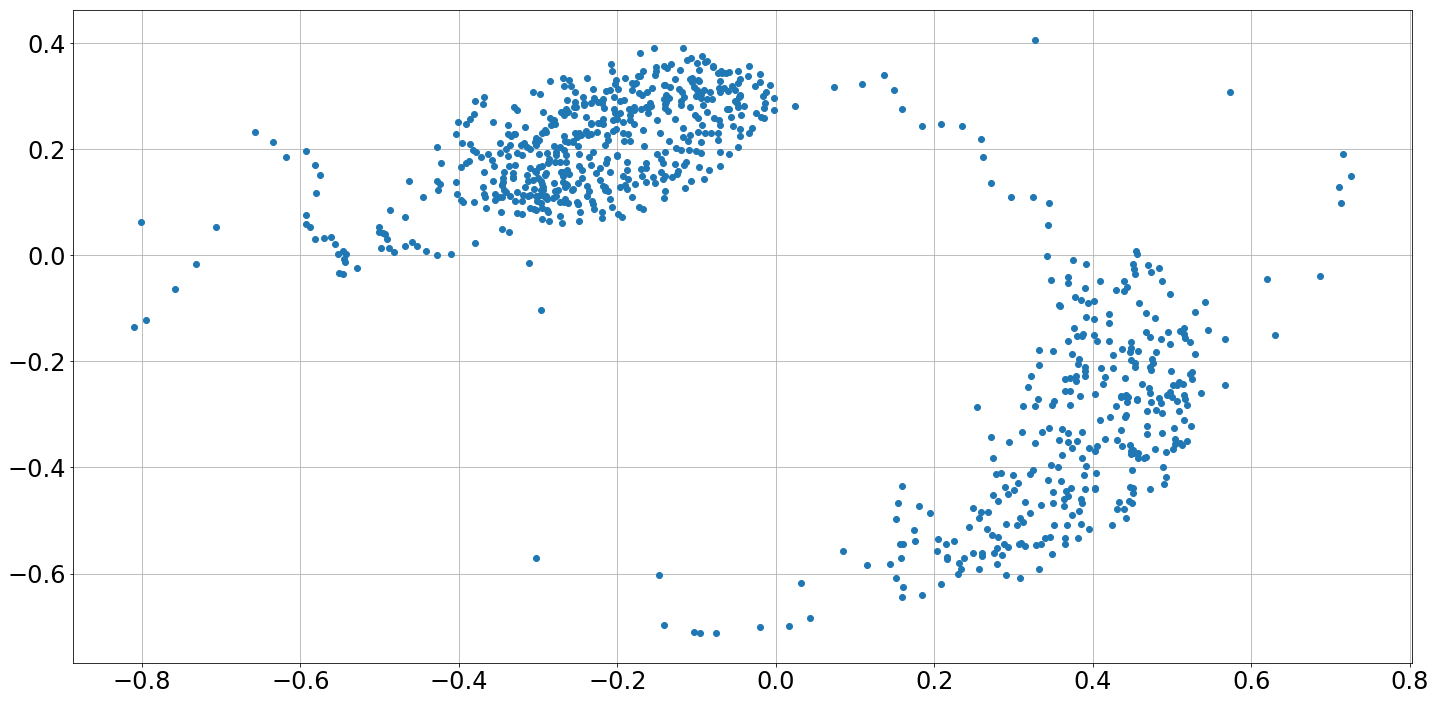

In [63]:
_ = plt.plot(resss[:,0], resss[:, 1], 'o')


plt.grid()
plt.savefig('./results/1_real_2D.png')
plt.show()

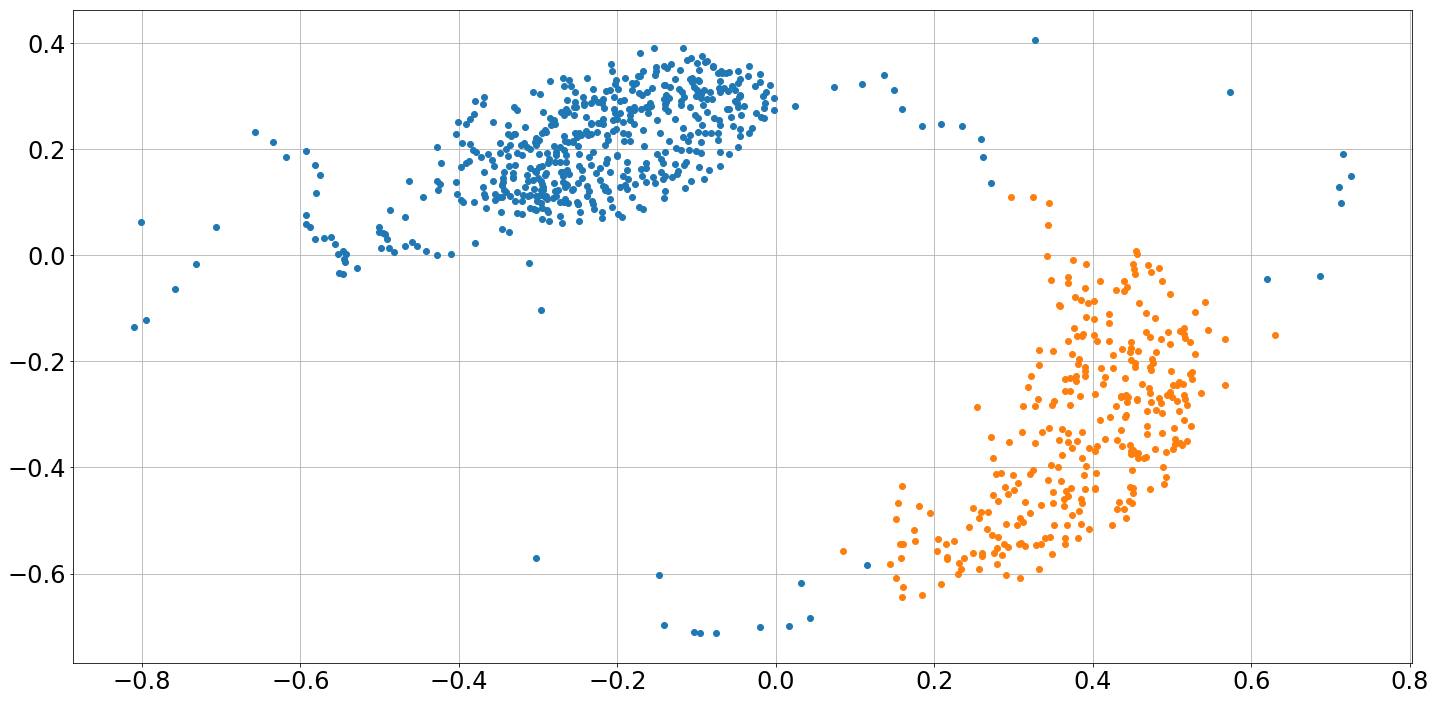

In [64]:
for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(resss[:, 0][ind], resss[:, 1][ind], 'o')

plt.grid()
plt.savefig('./results/1_real_2D_value.png')
plt.show()

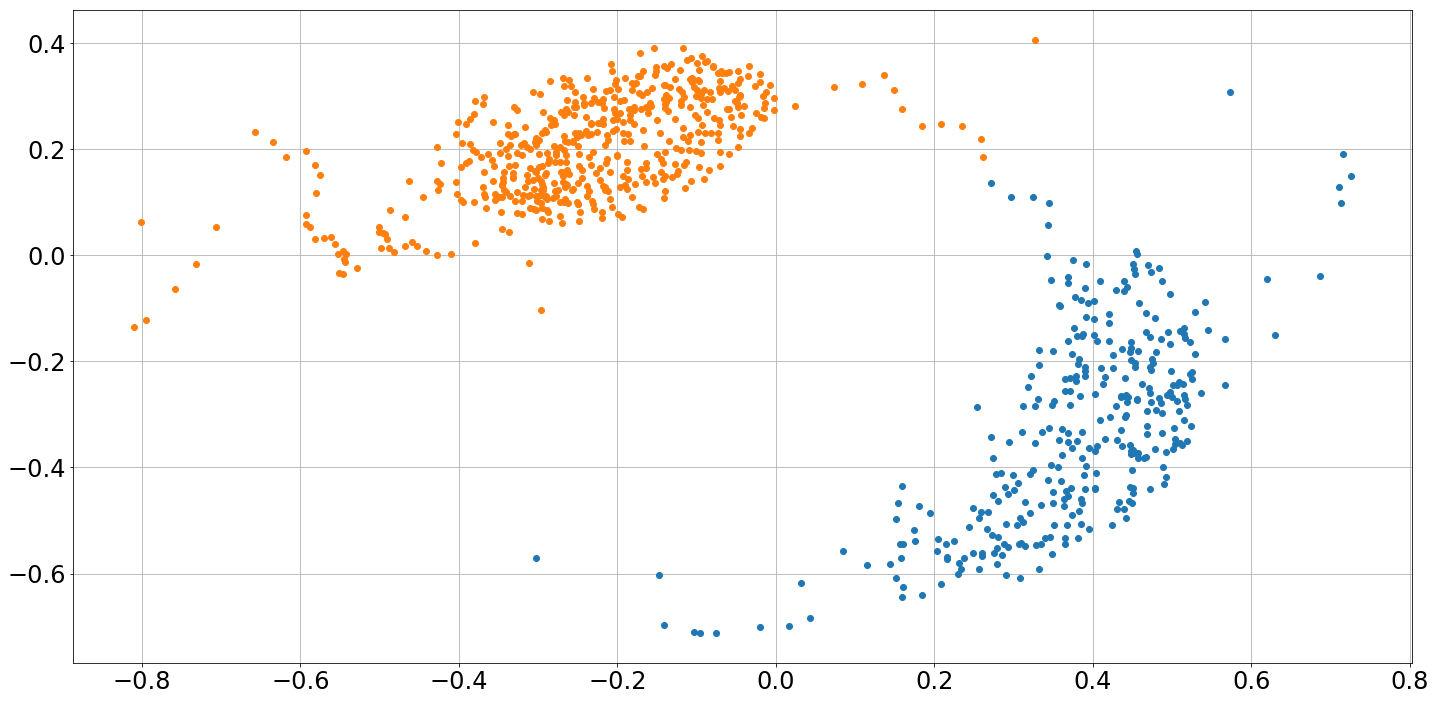

In [65]:
for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(resss[:, 0][ind], resss[:, 1][ind], 'o')


plt.grid()
plt.savefig('./results/1_real_2D_vector.png')
plt.show()

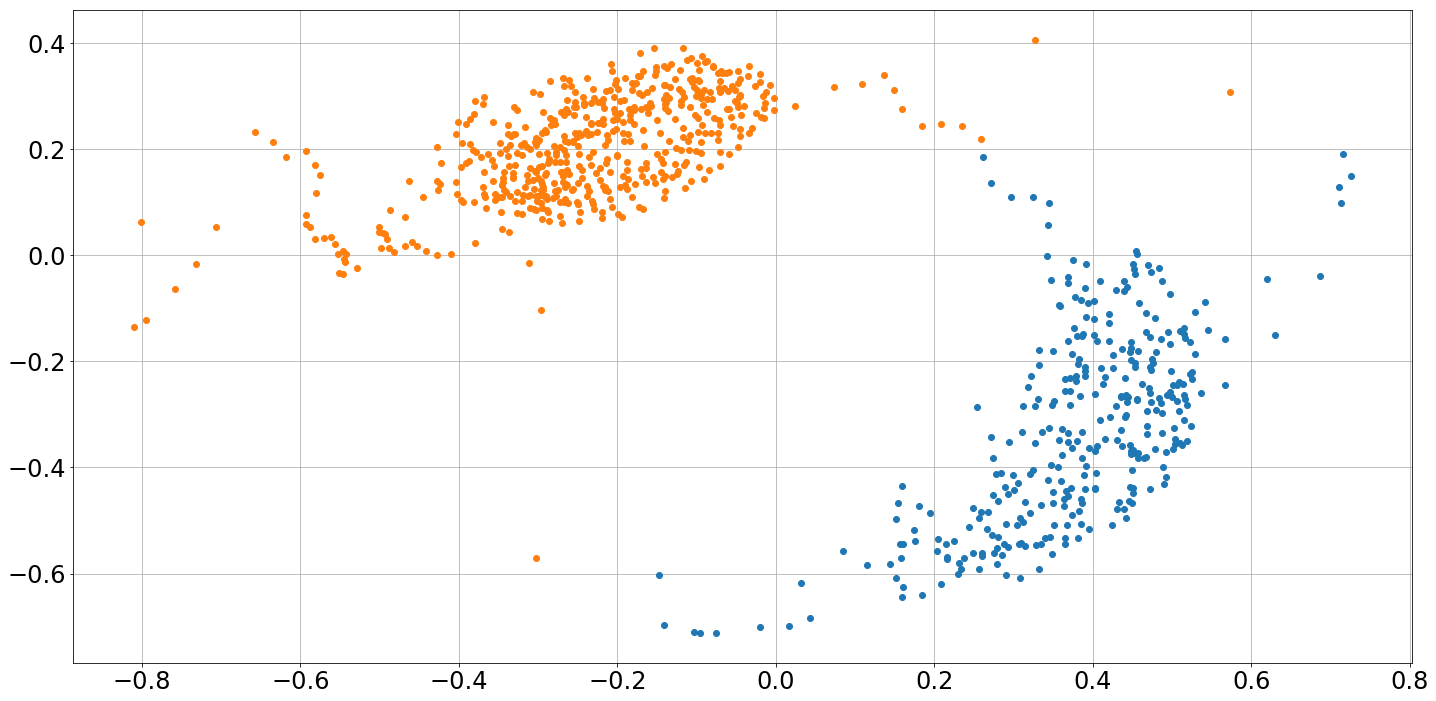

In [66]:
for t in np.unique(prediction_comb):
    ind = np.where(prediction_comb == t)
    _ = plt.plot(resss[:, 0][ind], resss[:, 1][ind], 'o')


plt.grid()
plt.savefig('./results/1_real_2D_comb.png')
plt.show()

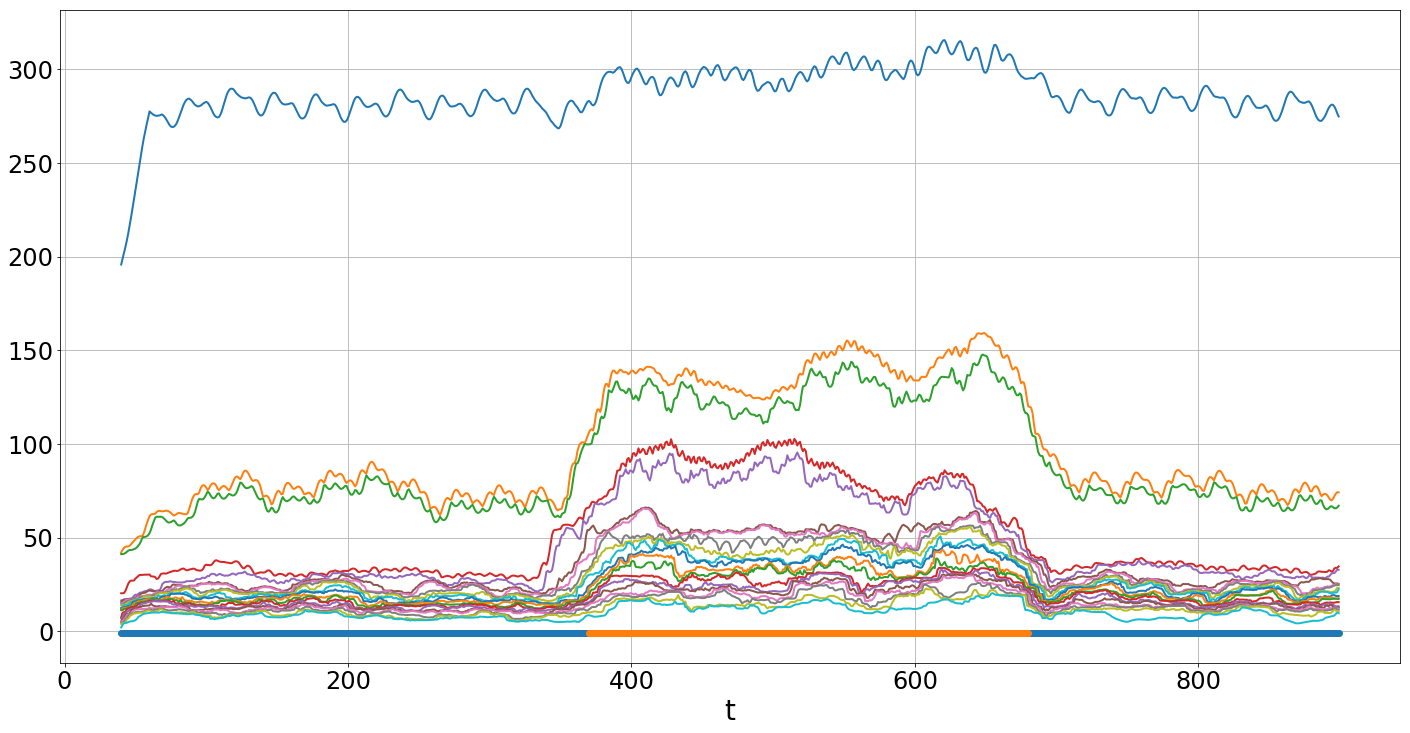

In [67]:
_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')

line = -np.ones_like(List_of_x)

for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(List_of_x[ind]+T, line[ind], 'o')


plt.grid()
plt.xlabel('t')
plt.show()

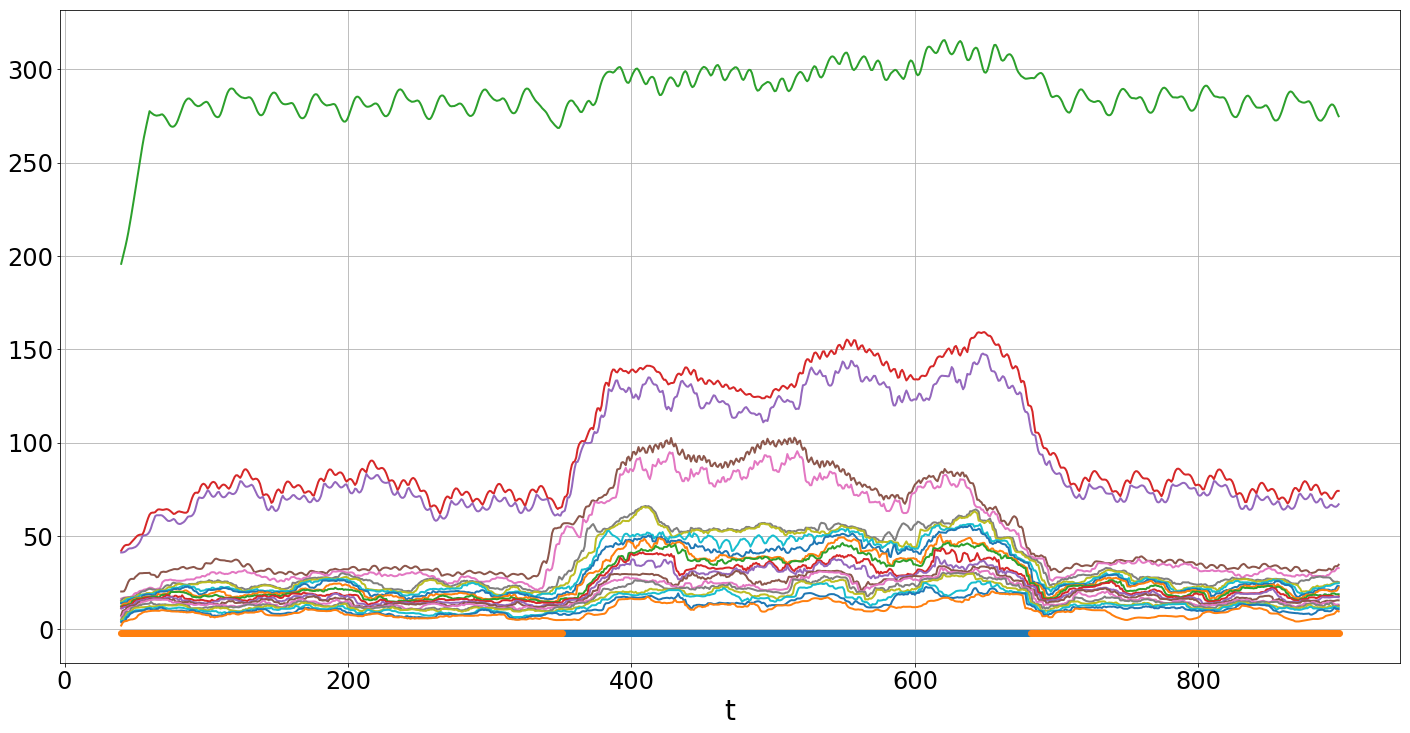

In [68]:
line = -2*np.ones_like(List_of_x)

for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(List_of_x[ind]+T, line[ind], 'o')

_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')



plt.grid()
plt.xlabel('t')
plt.show()

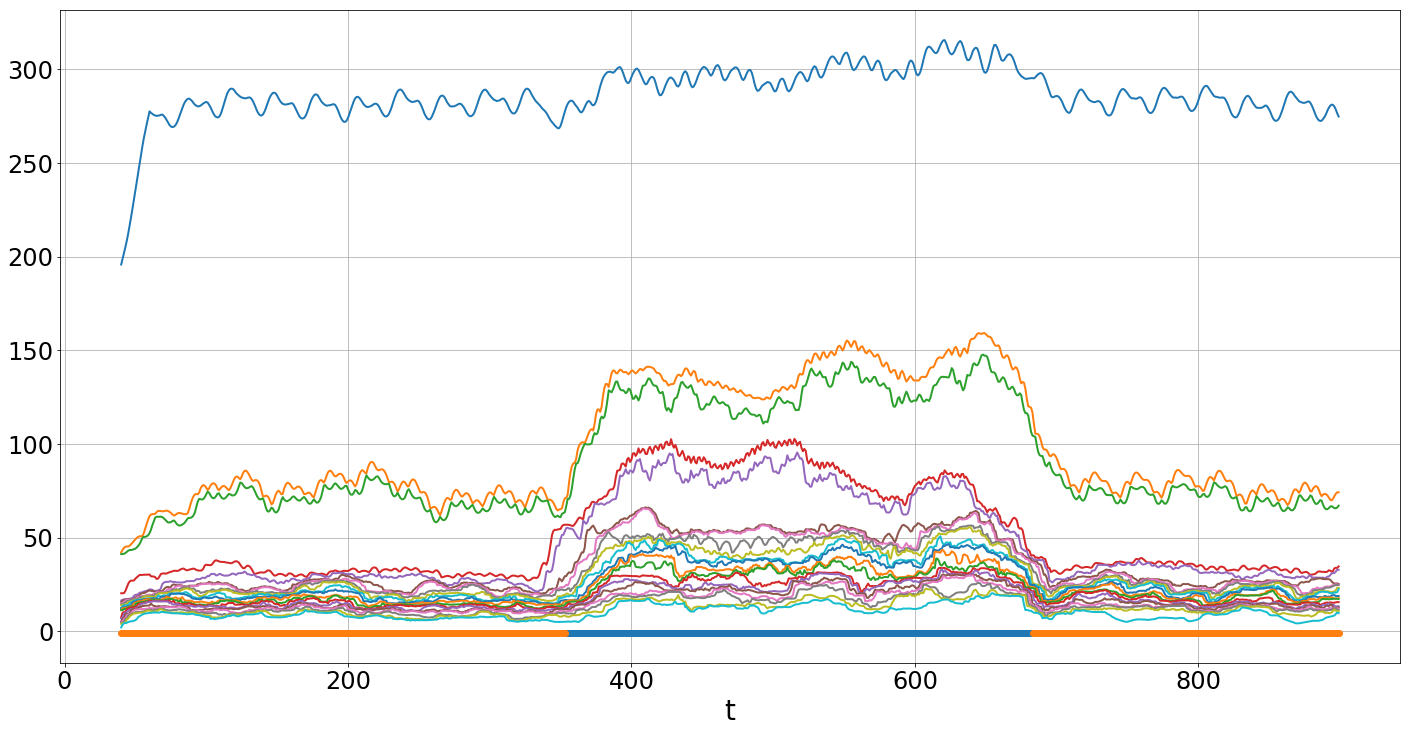

In [69]:
_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')

line = -np.ones_like(List_of_x)

for t in np.unique(prediction_comb):
    ind = np.where(prediction_comb == t)
    _ = plt.plot(List_of_x[ind]+T, line[ind], 'o')


plt.grid()
plt.xlabel('t')
plt.show()

In [70]:
model_pca = PCA(n_components=2)
result_pca = model_pca.fit_transform(result_pca_1)

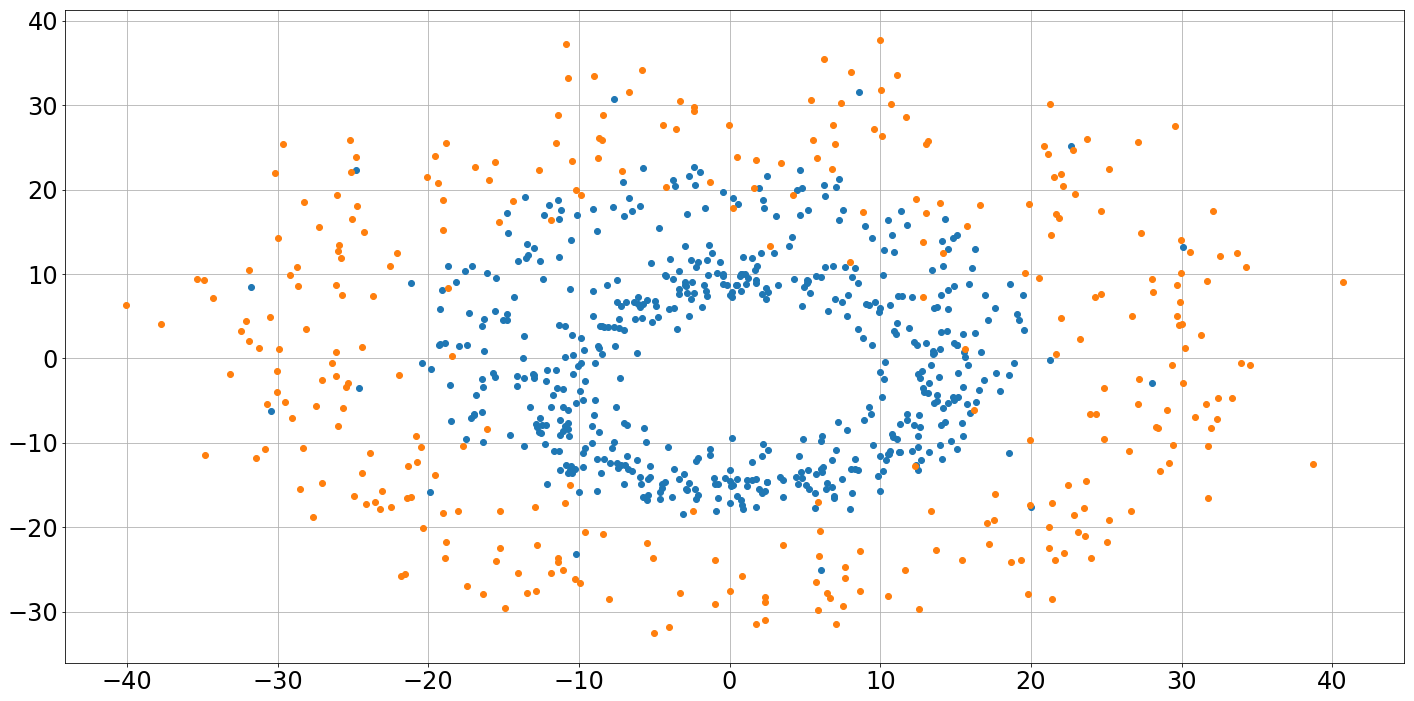

In [71]:
for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(result_pca[T:, 0][ind], result_pca[T:, 1][ind], 'o')

plt.grid()
plt.show()

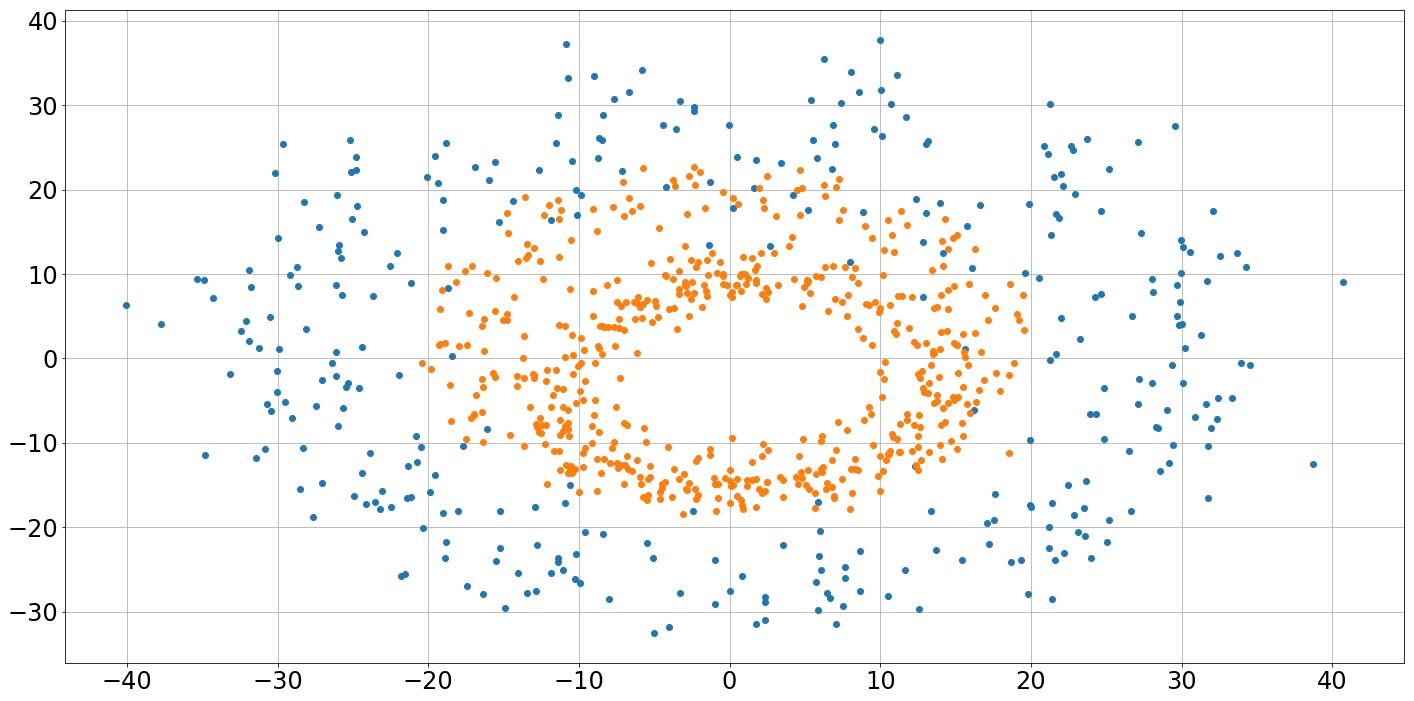

In [72]:
for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(result_pca[T:, 0][ind], result_pca[T:, 1][ind], 'o')

plt.grid()
plt.show()

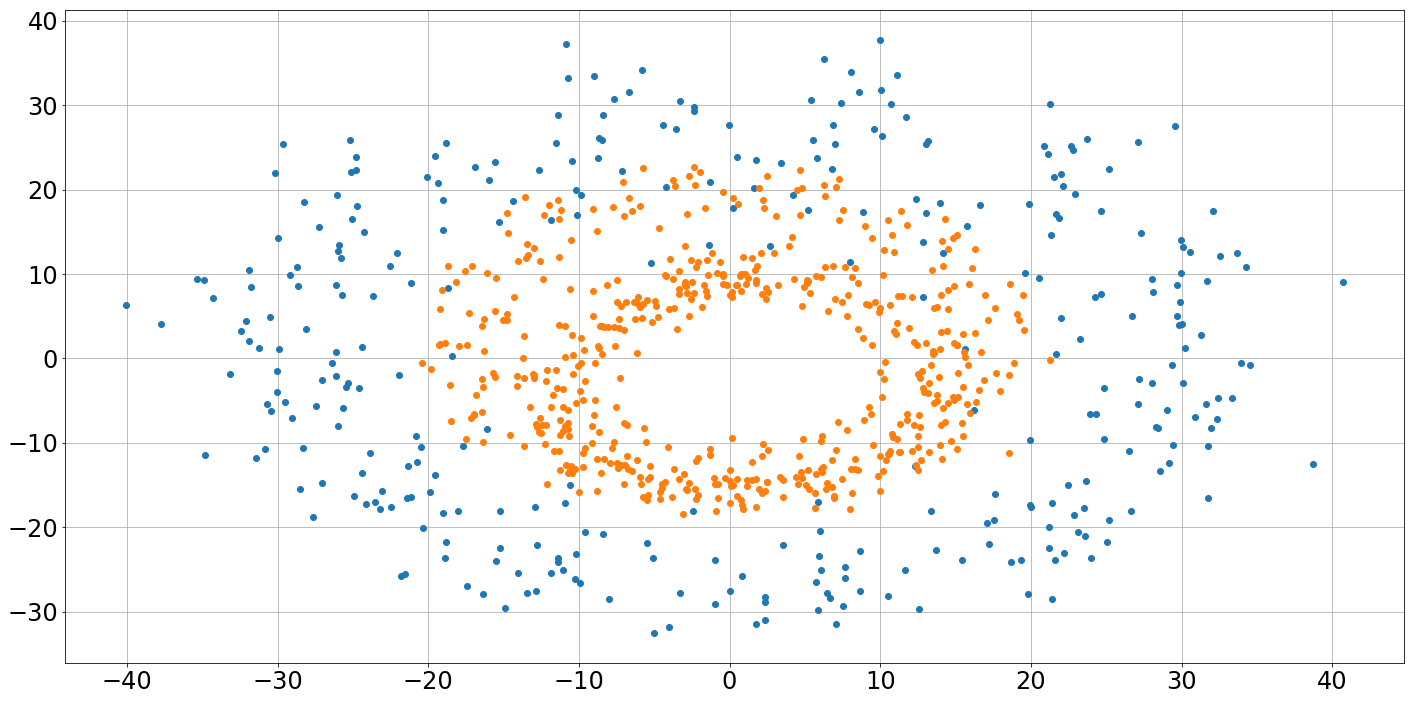

In [73]:
for t in np.unique(prediction_comb):
    ind = np.where(prediction_comb == t)
    _ = plt.plot(result_pca[T:, 0][ind], result_pca[T:, 1][ind], 'o')

plt.grid()
plt.show()

In [74]:
result_pca.shape

(880, 2)

In [75]:
rho = np.sqrt((result_pca**2).sum(axis = 1))

In [76]:
phi = np.arctan2(result_pca[:,0], result_pca[:,1])

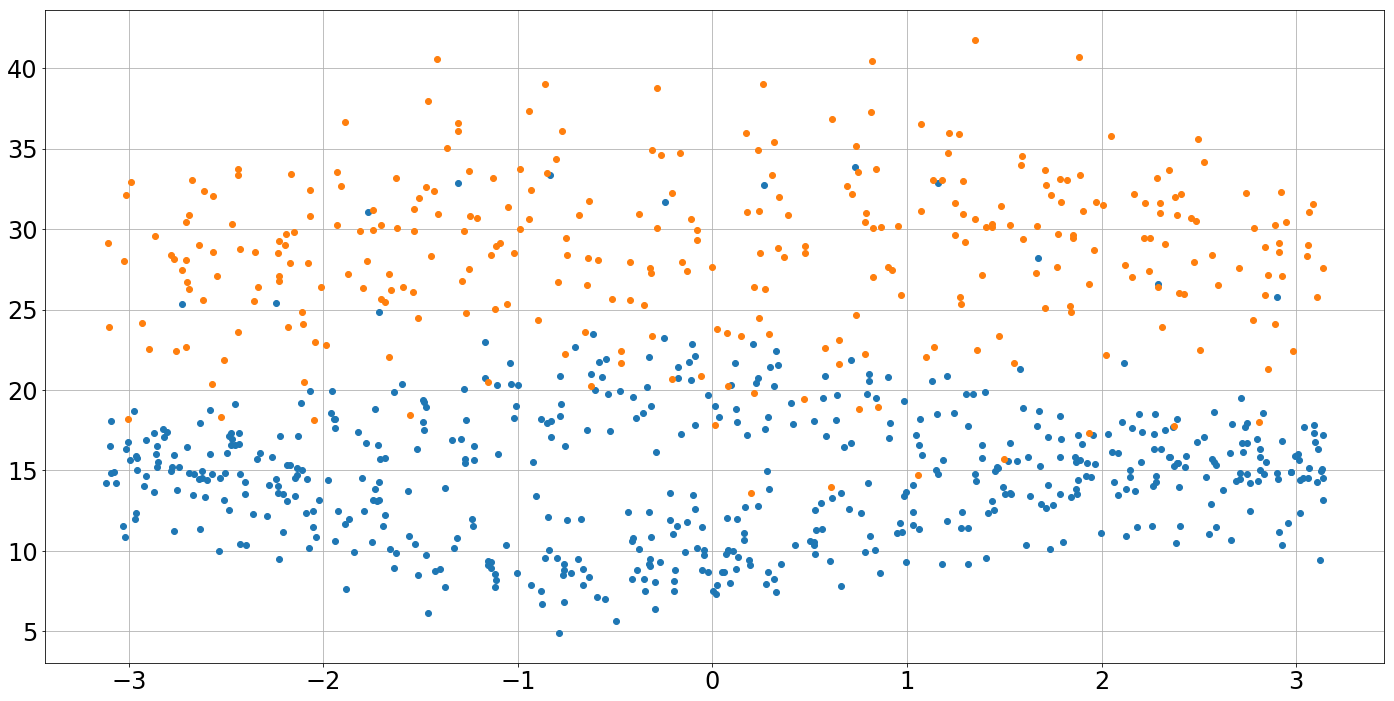

In [77]:
for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(phi[T:][ind], rho[T:][ind], 'o')


plt.grid()
plt.show()

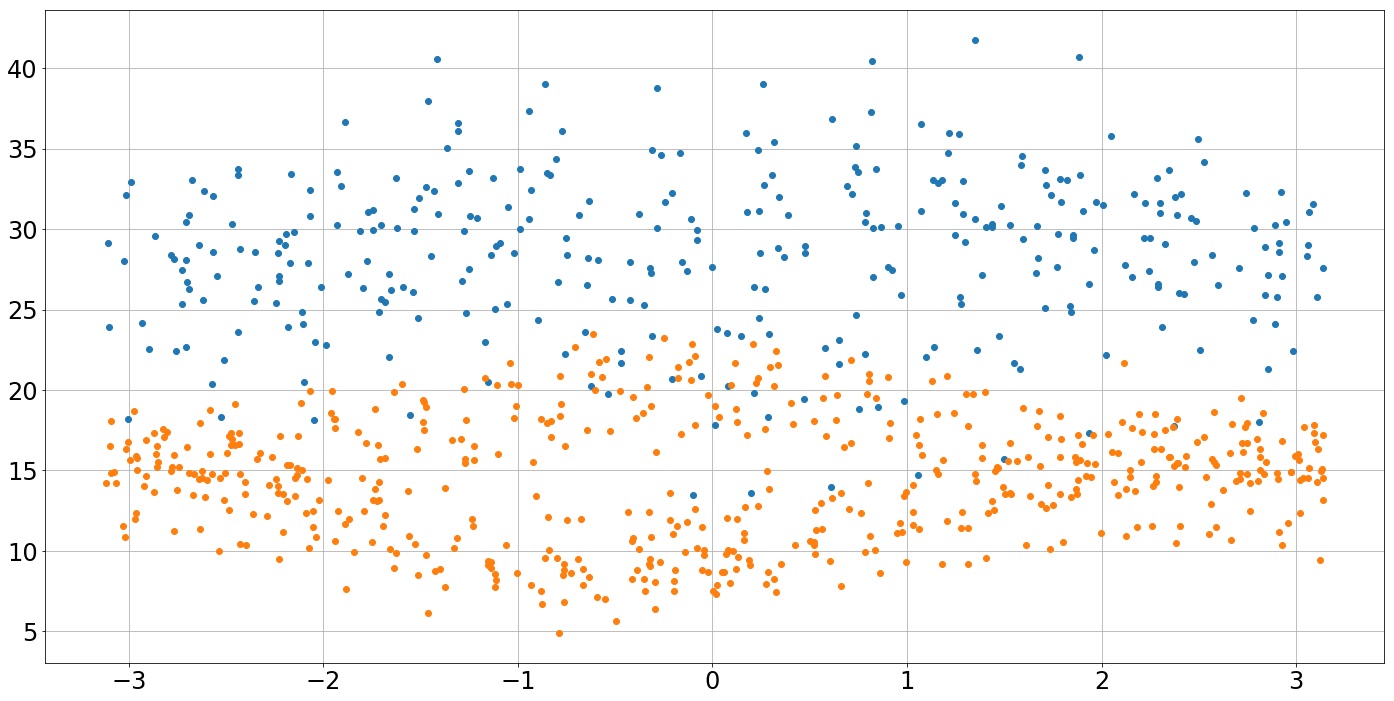

In [78]:
for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(phi[T:][ind], rho[T:][ind], 'o')


plt.grid()
plt.show()

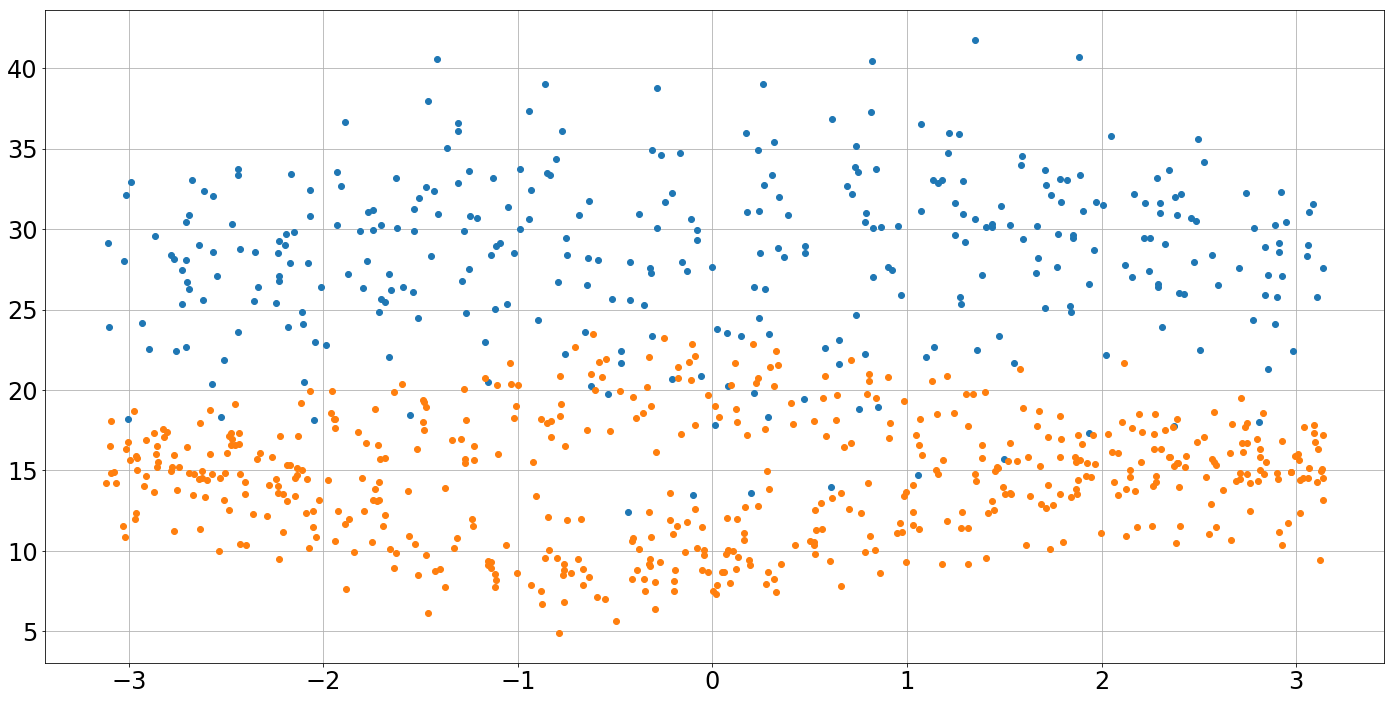

In [79]:
for t in np.unique(prediction_comb):
    ind = np.where(prediction_comb == t)
    _ = plt.plot(phi[T:][ind], rho[T:][ind], 'o')


plt.grid()
plt.show()

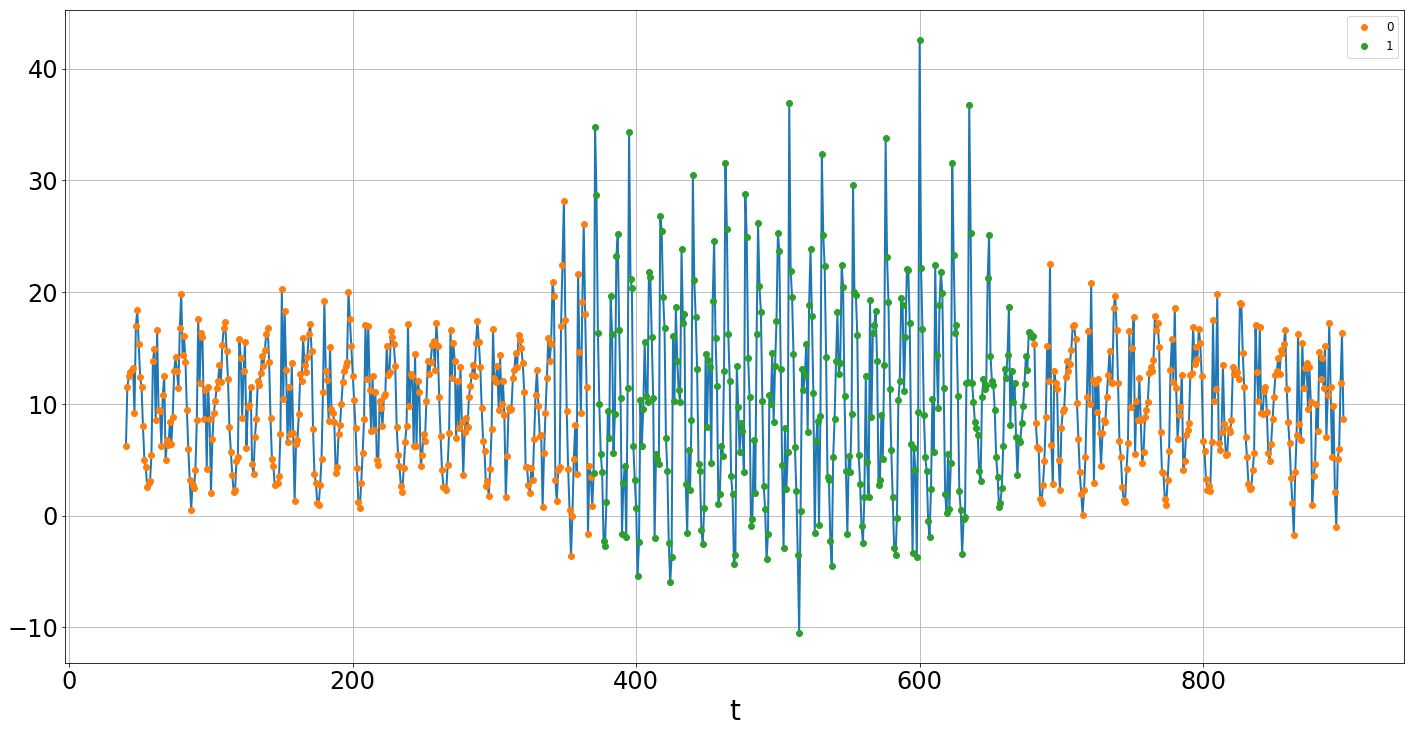

In [80]:
_ = plt.plot(List_of_x+T, X_test[0][2*T:], '-')

for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(List_of_x[ind]+T, X_test[0][2*T:][ind], 'o', label = str(t))




plt.grid()
plt.legend(loc = 'best')
plt.xlabel('t')
plt.savefig('./results/1_real_claster_value.png')
plt.show()

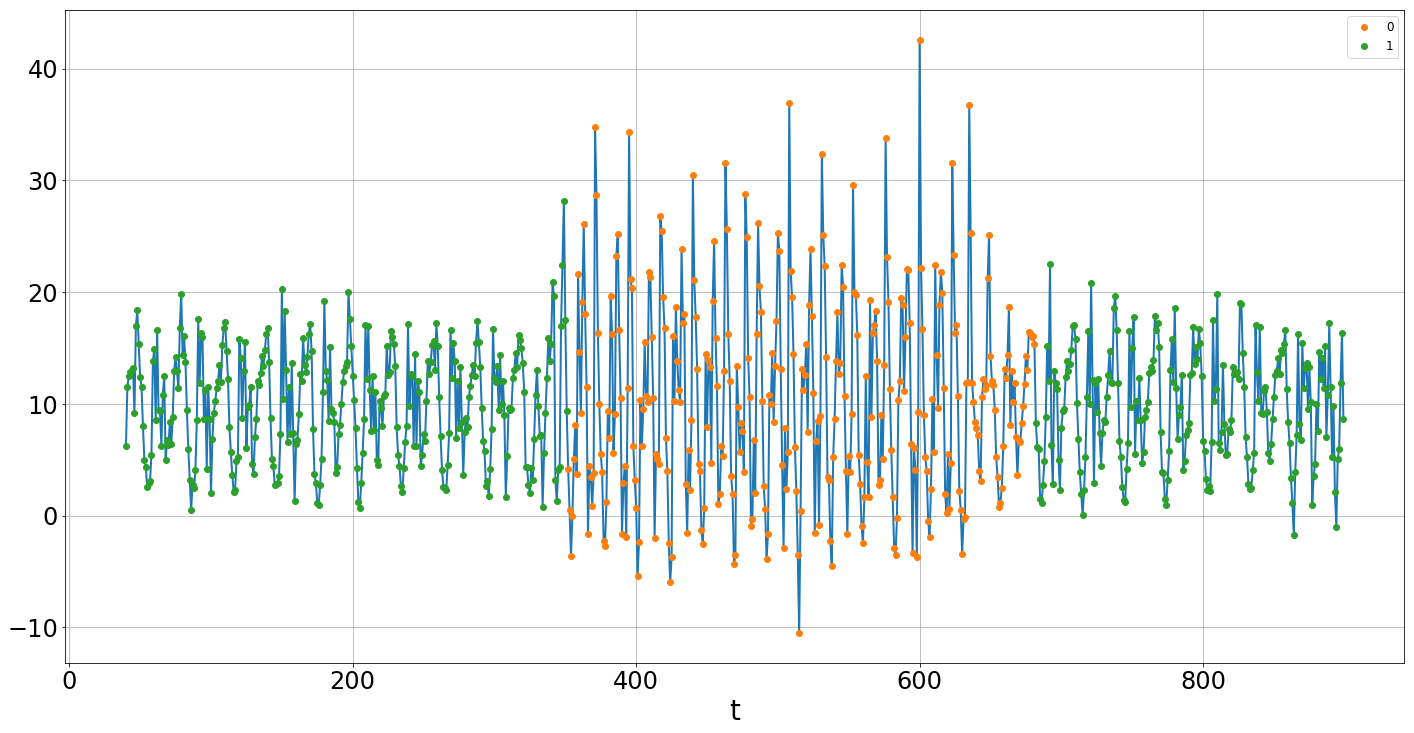

In [81]:
_ = plt.plot(List_of_x+T, X_test[0][2*T:], '-')

for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(List_of_x[ind]+T, X_test[0][2*T:][ind], 'o', label = str(t))



plt.grid()
plt.legend(loc = 'best')
plt.xlabel('t')
plt.savefig('./results/1_real_claster_vector.png')
plt.show()

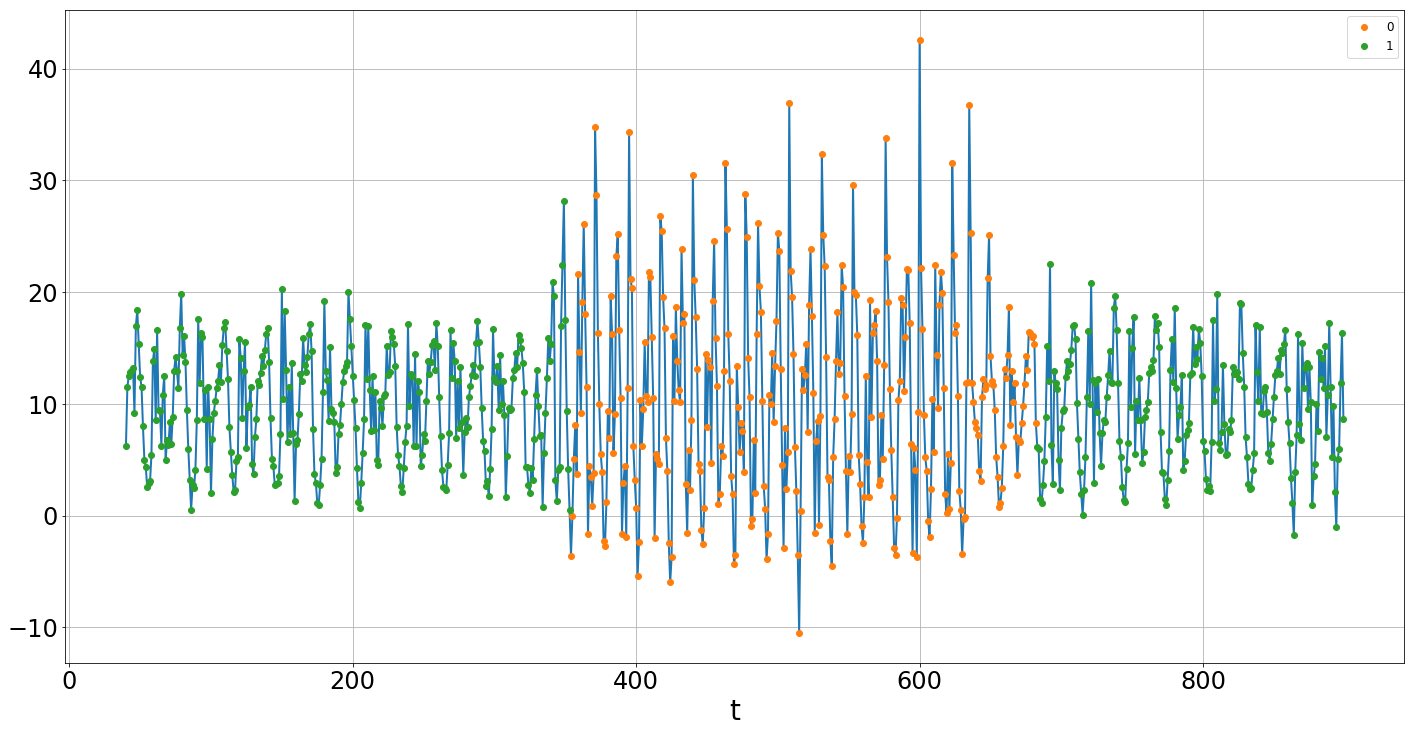

In [82]:
_ = plt.plot(List_of_x+T, X_test[0][2*T:], '-')

for t in np.unique(prediction_comb):
    ind = np.where(prediction_comb == t)
    _ = plt.plot(List_of_x[ind]+T, X_test[0][2*T:][ind], 'o', label = str(t))



plt.grid()
plt.legend(loc = 'best')
plt.xlabel('t')
plt.savefig('./results/1_real_claster_comb.png')
plt.show()